In [ ]:
#
#  Peak_analysis_gender_violence_calls.ipynb
#
#  MSc Physics of Complex Systems and Biophysics
#  Analysis and Visualization of Big Data
#
#  Created by Emma
#

In [453]:
# in order to access API
from sodapy import Socrata  
# libraries to work with dataframes, arrays, etc.
import pandas as pd
import numpy as np
# libraries for the plots
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
from plotly.graph_objs import *
# library scipy stats for extreme value analysis
import scipy.stats as ss
from scipy.stats import gumbel_r
from scipy.signal import find_peaks

In [287]:
# upload the dataset
client = Socrata("analisi.transparenciacatalunya.cat", None)
results = client.get("q2sg-894k", limit=117011)
calls_original_df = pd.DataFrame.from_records(results)

# show loaded table: 
calls_original_df

,data,any,duradasegons,diasetmana,mes,hora,llengua,comarca,ambitterritorial,provincia,...,viol_ncia_vic_ria,viol_ncia_detectada,motiu_trucada_2,_mbit_viol_ncia_2,detall_mbit_de_la_viol_ncia,tipus_assessorament_2,motiu_trucada_3,_mbit_de_la_viol_ncia_3,detall_mbit_3,tipus_assessorament_3
0,2013-01-01T00:00:00.000,2013,Entre 5 i 15 minuts,Dimarts,Gener,1899-12-31T01:00:00.000,Castellà,Barcelonès,Metropolità,Barcelona,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-01T00:00:00.000,2013,Menys de 5 minuts,Dimarts,Gener,1899-12-31T03:20:00.000,Castellà,Barcelonès,Metropolità,Barcelona,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-01T00:00:00.000,2013,Entre 5 i 15 minuts,Dimarts,Gener,1899-12-31T19:07:00.000,Castellà,Barcelonès,Metropolità,Barcelona,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-01T00:00:00.000,2013,Menys de 5 minuts,Dimarts,Gener,1899-12-31T16:37:00.000,Castellà,Barcelonès,Metropolità,Barcelona,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-01T00:00:00.000,2013,Entre 5 i 15 minuts,Dimarts,Gener,1899-12-31T18:02:00.000,Castellà,Barcelonès,Metropolità,Barcelona,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117006,2022-08-31T00:00:00.000,2022,Entre 15 i 30 minuts,Dimecres,Agost,1899-12-31T16:57:38.000,Castellà,Maresme,Metropolità,Barcelona,...,No,No consta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117007,2022-08-31T00:00:00.000,2022,Més de 30 minuts,Dimecres,Agost,1899-12-31T07:37:27.000,Castellà,Barcelonès,Metropolità,Barcelona,...,No,Sí,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117008,2022-08-31T00:00:00.000,2022,Entre 5 i 15 minuts,Dimecres,Agost,1899-12-31T11:39:19.000,Castellà,Baix Llobregat,Metropolità,Barcelona,...,No,Sí,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117009,2022-08-31T00:00:00.000,2022,Entre 5 i 15 minuts,Dimecres,Agost,1899-12-31T12:24:00.000,Castellà,Barcelonès,Metropolità,Barcelona,...,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [305]:
# apply some filters to the original data frame
# First, create a column as a time date data type
calls_original_df["data_date_time"] = pd.to_datetime(calls_original_df.data)
# calls_df["hora2"] = pd.to_datetime(calls_df.hora)
# Then, all the calls that ask for information are eliminated, obtaining only the ones that call for sexist violence
calls_filter_df = calls_original_df[calls_original_df['motiutrucada']=='Violència masclista']
# Finally, all the calls that do not come from the victim are also eliminated, since that is the data we want to analyze
calls_filter_df = calls_filter_df[calls_filter_df['personaquetruca']=='La pròpia usuària']

# Moreover, eliminate the data from the year 2022 since is not finished
calls_df = calls_filter_df[calls_filter_df['any']!='2022']
calls_df = calls_filter_df[calls_filter_df['any']!='2021']
calls_df = calls_filter_df[calls_filter_df['any']!='2020']

In [396]:
# Since the onnly information used is the numbers of calls by date, the data frame can be reduced to 
calls_df = calls_df[['data_date_time']]
calls_df

,data_date_time
0,2013-01-01
1,2013-01-01
2,2013-01-01
3,2013-01-01
4,2013-01-01
...,...
117003,2022-08-31
117004,2022-08-31
117005,2022-08-31
117007,2022-08-31


In [286]:
# in order to study each year independently, the dataset is splitted by years
# this step is manual, could be improved
calls_df_2013 = calls_df[calls_df.data_date_time.dt.year==2013]
calls_df_2014 = calls_df[calls_df.data_date_time.dt.year==2014]
calls_df_2015 = calls_df[calls_df.data_date_time.dt.year==2015]
calls_df_2016 = calls_df[calls_df.data_date_time.dt.year==2016]
calls_df_2017 = calls_df[calls_df.data_date_time.dt.year==2017]
calls_df_2018 = calls_df[calls_df.data_date_time.dt.year==2018]
calls_df_2019 = calls_df[calls_df.data_date_time.dt.year==2019]
calls_df_2020 = calls_df[calls_df.data_date_time.dt.year==2020]
calls_df_2021 = calls_df[calls_df.data_date_time.dt.year==2021]

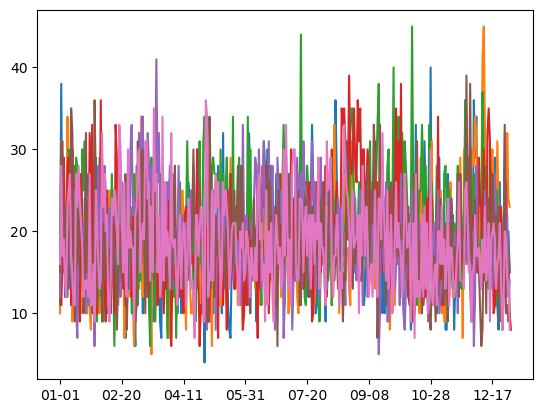

In [318]:
# First plot: plotting all the years together in order to see if there is any specific date that stands out
#             or any relevant information   
ax = calls_df_2013.data_date_time.apply(lambda x: x.replace(year=2012)).dt.strftime('%m-%d').value_counts().sort_index().plot()
calls_df_2014.data_date_time.apply(lambda x: x.replace(year=2012)).dt.strftime('%m-%d').value_counts().sort_index().plot(ax=ax)
calls_df_2015.data_date_time.apply(lambda x: x.replace(year=2012)).dt.strftime('%m-%d').value_counts().sort_index().plot(ax=ax)
calls_df_2016.data_date_time.apply(lambda x: x.replace(year=2012)).dt.strftime('%m-%d').value_counts().sort_index().plot(ax=ax)
calls_df_2017.data_date_time.apply(lambda x: x.replace(year=2012)).dt.strftime('%m-%d').value_counts().sort_index().plot(ax=ax)
calls_df_2018.data_date_time.apply(lambda x: x.replace(year=2012)).dt.strftime('%m-%d').value_counts().sort_index().plot(ax=ax)
calls_df_2019.data_date_time.apply(lambda x: x.replace(year=2012)).dt.strftime('%m-%d').value_counts().sort_index().plot(ax=ax)
plt.show()

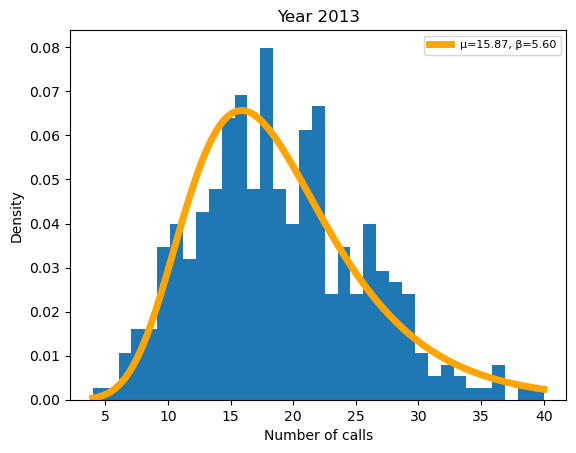

15.86843926172233 5.6014061614176125


In [298]:
# Extreme value analysis: Gumbel distribution
# In order to choose a threshold

year_in_question = calls_df_2013
year = '2013'

hist0, bins0 = np.histogram(year_in_question.data_date_time.apply(lambda x: x.replace(year=2012)).dt.strftime('%m-%d').value_counts(),bins=100, density=True)
loc,scale= gumbel_r.fit(year_in_question.data_date_time.apply(lambda x: x.replace(year=2012)).dt.strftime('%m-%d').value_counts().to_numpy())

plt.hist(year_in_question.data_date_time.apply(lambda x: x.replace(year=2012)).dt.strftime('%m-%d').value_counts(), bins=35,density=True)
plt.plot(bins0, gumbel_r.pdf(bins0, loc=loc,scale=scale),color='orange', lw=5, alpha=1, label=chr(956)+'='+format(loc,'.2f')+', '+chr(946)+'='+format(scale,'.2f'))
plt.legend(loc=1, prop={'size': 8})
plt.xlabel('Number of calls')
plt.ylabel('Density')
plt.title('Year '+year)
plt.show()

print(loc,scale)

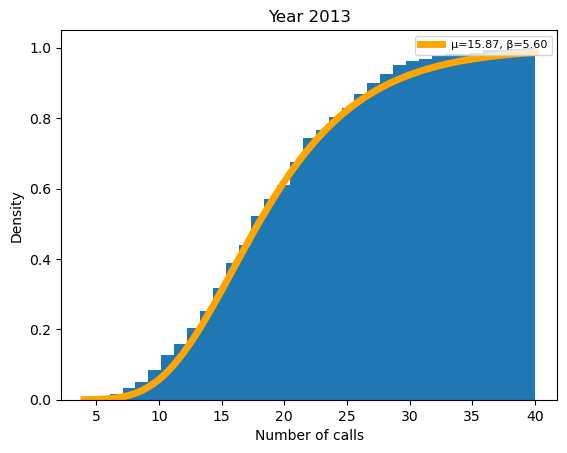

15.86843926172233 5.6014061614176125


In [300]:
year_in_question = calls_df_2013
year = '2013'


hist0, bins0 = np.histogram(year_in_question.data_date_time.apply(lambda x: x.replace(year=2012)).dt.strftime('%m-%d').value_counts(),bins=100, density=True)
#loc, scale = invweibull.fit(calls_df_2013.data_date_time.apply(lambda x: x.replace(year=2012)).dt.strftime('%m-%d').value_counts().to_numpy())
#dist = invweibull(loc=loc,scale=scale)
loc,scale= gumbel_r.fit(year_in_question.data_date_time.apply(lambda x: x.replace(year=2012)).dt.strftime('%m-%d').value_counts().to_numpy())

plt.hist(year_in_question.data_date_time.apply(lambda x: x.replace(year=2012)).dt.strftime('%m-%d').value_counts(), bins=35,density=True,cumulative=True)
plt.plot(bins0, gumbel_r.cdf(bins0, loc=loc,scale=scale),color='orange', lw=5, alpha=1, label=chr(956)+'='+format(loc,'.2f')+', '+chr(946)+'='+format(scale,'.2f'))
plt.legend(loc=1, prop={'size': 8})
plt.xlabel('Number of calls')
plt.ylabel('Density')
plt.title('Year '+year)
plt.show()

print(loc,scale)

In [387]:
one_year_df=pd.DataFrame()

one_year_df['2013'] = calls_df_2013.data_date_time.apply(lambda x: x.replace(year=2012)).value_counts().sort_index()
one_year_df['2014'] = calls_df_2014.data_date_time.apply(lambda x: x.replace(year=2012)).value_counts().sort_index()
one_year_df['2015'] = calls_df_2015.data_date_time.apply(lambda x: x.replace(year=2012)).value_counts().sort_index()
one_year_df['2016'] = calls_df_2016.data_date_time.apply(lambda x: x.replace(year=2012)).value_counts().sort_index()
one_year_df['2017'] = calls_df_2017.data_date_time.apply(lambda x: x.replace(year=2012)).value_counts().sort_index()
one_year_df['2018'] = calls_df_2018.data_date_time.apply(lambda x: x.replace(year=2012)).value_counts().sort_index()
one_year_df['2019'] = calls_df_2019.data_date_time.apply(lambda x: x.replace(year=2012)).value_counts().sort_index()
#calls_df_2020.data_date_time.apply(lambda x: x.replace(year=2012)).value_counts().sort_index()
#calls_df_2021.data_date_time.apply(lambda x: x.replace(year=2012)).value_counts().sort_index()

one_year_df['diames']=pd.to_datetime(one_year_df.index)
one_year_df['diames2']=one_year_df['diames'].dt.strftime('%d-%m')
one_year_df

,2013,2014,2015,2016,2017,2018,2019,diames,diames2
2012-01-01,16,10,11,14,12,15,16,2012-01-01,01-01
2012-01-02,38,31,24,11,19,31,28,2012-01-02,02-01
2012-01-03,15,26,21,16,22,31,17,2012-01-03,03-01
2012-01-04,28,17,20,29,22,19,19,2012-01-04,04-01
2012-01-05,12,20,23,21,15,23,14,2012-01-05,05-01
...,...,...,...,...,...,...,...,...,...
2012-12-27,24,28,17,26,32,33,20,2012-12-27,27-12
2012-12-28,16,14,21,19,19,10,19,2012-12-28,28-12
2012-12-29,18,32,19,17,22,11,14,2012-12-29,29-12
2012-12-30,20,24,18,10,12,9,14,2012-12-30,30-12


In [708]:
# start new data frame
calls_by_day_df=pd.DataFrame()
# count calls per day yearly from 2013 to 2019
for i_year in range(2013,2020):
    calls_df_i_year = calls_df[calls_df.data_date_time.dt.year==i_year]
    calls_by_day_df[str(i_year)] = calls_df_i_year.data_date_time.apply(lambda x: x.replace(year=2012)).value_counts().sort_index()
# add new column with date in datetime format
calls_by_day_df['date']=pd.to_datetime(calls_by_day_df.index)

# sum specific columns: copy of the dataframe to remove date column
aux = calls_by_day_df.copy() 
del aux['date']
# add new column with sum over years of calls by day
calls_by_day_df['suma'] = aux.sum(axis=1) 

In [711]:
mu = calls_by_day_df.suma.mean()
mu_max = max(calls_by_day_df.suma)
mu_min = min(calls_by_day_df.suma)
#####

time_series = calls_by_day_df.suma

indices = find_peaks(time_series)[0]
idx, properties = find_peaks(time_series)
pics = time_series[idx]

pics = pics[pics> (mu_max-mu)*0.5+mu]

print((mu_max-mu)*0.5+mu)


layout = Layout(
    paper_bgcolor='white',
    plot_bgcolor='rgba(0,0,0,0)',
     width=900, height=650
)

fig = go.Figure(layout=layout)
fig.add_trace(go.Scatter(
    x=aux.index,
    y=time_series,
    mode='lines',
    name='Original Plot'
))

fig.add_trace(go.Scatter(
    x=pics.index,
    y=pics,
    text=pics.index,
    textposition="bottom center",
    mode='markers',
    marker=dict(
        size=8,
        color='orange',
        symbol='circle'
    ),
    name='Detected Peaks'
    
))

fig.update_xaxes(tickformat='%d-%b')

fig.add_hline(y=(mu_max-mu)*0.5+mu, line_width=1, line_dash="dash", line_color="green")
fig.add_hline(y=mu, line_width=1, line_dash="dash", line_color="green")
fig.add_hline(y=mu_max, line_width=1, line_dash="dash", line_color="green")
#fig.add_hline(y=mu_min, line_width=1, line_dash="dash", line_color="green")
fig.add_hrect(y0=(mu_max-mu)*0.5+mu, y1=mu_max, line_width=0, fillcolor="orange", opacity=0.3)


fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

#fig.update_layout(title='2013-2019', xaxis_title='Date', yaxis_title='Number of calls') 
fig.update_layout( xaxis_title='Date', yaxis_title='Number of calls') 
fig.update_layout(showlegend=False) 
fig.show()

159.93013698630136


In [719]:
# start new data frame
calls_by_day_df=pd.DataFrame()
# count calls per day yearly from 2013 to 2019
for i_year in range(2013,2020):
    calls_df_i_year = calls_df[calls_df.data_date_time.dt.year==i_year]
    calls_by_day_df[str(i_year)] = calls_df_i_year.data_date_time.apply(lambda x: x.replace(year=2012)).value_counts().sort_index()
# add new column with date in datetime format
calls_by_day_df['date']=pd.to_datetime(calls_by_day_df.index)

# sum specific columns: copy of the dataframe to remove date column
aux = calls_by_day_df.copy() 
del aux['date']
# add new column with sum over years of calls by day
calls_by_day_df['suma'] = aux.sum(axis=1) 
calls_by_day_df['rollmean7'] = calls_by_day_df.suma.rolling(7,center=True).mean()
calls_by_day_df['rollmean15'] = calls_by_day_df.suma.rolling(15,center=True).mean()
calls_by_day_df['rollmean30'] = calls_by_day_df.suma.rolling(30,center=True).mean()


calls_by_day_df




aux = calls_by_day_df

aux = aux.apply(pd.to_numeric, errors='coerce')
aux = aux.dropna()



layout = Layout(
    paper_bgcolor='white',
    plot_bgcolor='rgba(0,0,0,0)',
     width=900, height=650
)

fig = go.Figure(layout=layout)
fig.add_trace(go.Scatter(
    x=aux.index,
    y=aux.rollmean7,
    mode='lines',
    name='Rolling mean: 7',
        line=dict(color='black', width=1)

))

fig.add_trace(go.Scatter(
    x=aux.index,
    y= aux.rollmean15,
    mode='lines',
    name='Rolling mean: 15',
    line=dict(color='magenta', width=4)
))

fig.add_trace(go.Scatter(
    x=aux.index,
    y=aux.rollmean30,
    mode='lines',
    name='Rolling mean: 30',
    line=dict(color='green', width=6)
))


fig.update_xaxes(tickformat='%d-%b')

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='gray')
#fig.update_layout(title='2013-2019', xaxis_title='Date', yaxis_title='Number of calls') 
fig.update_layout( xaxis_title='Date', yaxis_title='Number of calls') 
fig.update_layout(showlegend=True) 
fig.show()



In [717]:
calls_by_day_df


,2013,2014,2015,2016,2017,2018,2019,date,suma,rollmean7,rollmean15,rollmean30
2012-01-01,16,10,11,14,12,15,16,2012-01-01,94,NaN,NaN,NaN
2012-01-02,38,31,24,11,19,31,28,2012-01-02,182,NaN,NaN,NaN
2012-01-03,15,26,21,16,22,31,17,2012-01-03,148,NaN,NaN,NaN
2012-01-04,28,17,20,29,22,19,19,2012-01-04,154,NaN,NaN,NaN
2012-01-05,12,20,23,21,15,23,14,2012-01-05,128,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-27,24,28,17,26,32,33,20,2012-12-27,180,119.571429,132.000000,138.733333
2012-12-28,16,14,21,19,19,10,19,2012-12-28,118,117.857143,130.200000,138.200000
2012-12-29,18,32,19,17,22,11,14,2012-12-29,133,120.142857,129.933333,137.266667
2012-12-30,20,24,18,10,12,9,14,2012-12-30,107,116.142857,128.000000,136.600000


In [547]:
# confirmation: it removes de 29th of February, which is what we want
calls_by_day_df[calls_by_day_df.date.dt.month==2]

,2013,2014,2015,2016,2017,2018,2019,date,suma
2012-02-01,21,17,16,25,28,18,16,2012-02-01,141
2012-02-02,12,10,29,15,14,16,13,2012-02-02,109
2012-02-03,14,30,12,36,23,19,14,2012-02-03,148
2012-02-04,27,16,12,16,20,9,32,2012-02-04,132
2012-02-05,25,16,9,24,14,21,23,2012-02-05,132
2012-02-06,12,17,17,15,28,14,27,2012-02-06,130
2012-02-07,19,11,15,9,25,24,20,2012-02-07,123
2012-02-08,10,11,12,25,17,20,22,2012-02-08,117
2012-02-09,12,11,22,18,17,14,11,2012-02-09,105
2012-02-10,11,25,17,20,23,18,9,2012-02-10,123


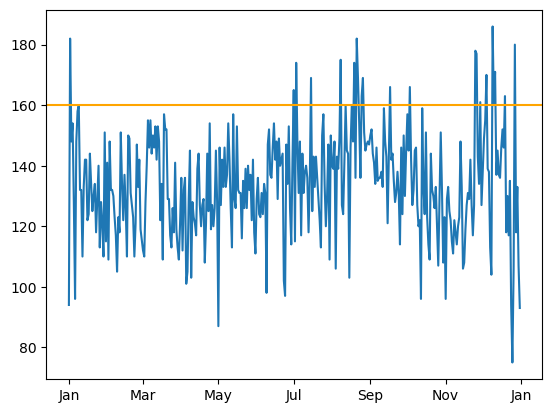

In [554]:
# for some reason this value_counts is bigger than the sum of the calls by day every year -> we remove it
# ax = calls_df.data_date_time.apply(lambda x: x.replace(year=2012)).dt.strftime('%m-%d').value_counts().sort_index().plot()

fig = plt.figure(1)
ax = plt.subplot(111)

line = ax.plot(calls_by_day_df.date,calls_by_day_df.suma)
myFmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_formatter(myFmt)

ax.axhline(y=160,color='orange')
#ax.axhline(y=max(calls_by_day_df.suma),color='orange',linestyle='dashed')
plt.show()
# 29 february is an exception

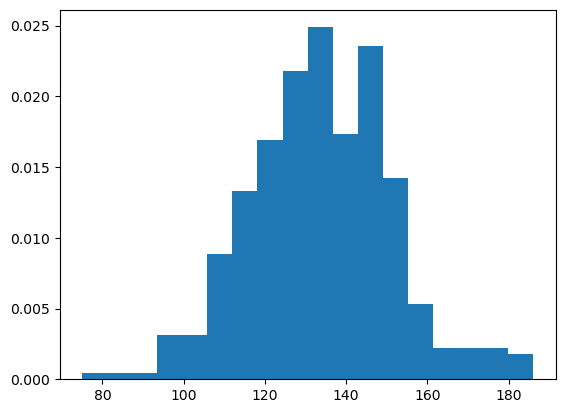

In [549]:
#calls_df.data_date_time.apply(lambda x: x.replace(year=2012)).dt.strftime('%m-%d').value_counts().sort_index().hist(bins='auto',density=True,label='2013-2019')
fig = plt.figure(1)
ax = plt.subplot(111)

line = ax.hist(one_year_df.suma,bins='auto',density=1,cumulative=0,label='2013-2019')
#line2 = ax.hist(one_year_df.suma,bins='auto',density=True,cumulative=1,label='2013-2019')

plt.show()

In [611]:
year_in_question = calls_df_2013
year = '2013'


##### Defining criteria or threshold
mu = year_in_question.data_date_time.value_counts().sort_index().mean()
mu_max = max(year_in_question.data_date_time.value_counts().sort_index())
mu_min = min(year_in_question.data_date_time.value_counts().sort_index())
#####

time_series = calls_by_day_df[year]

indices = find_peaks(time_series)[0]
idx, properties = find_peaks(time_series)
pics = time_series[idx]

pics = pics[pics> (mu_max-mu)*0.5+mu]


layout = Layout(
    paper_bgcolor='white',
    plot_bgcolor='rgba(0,0,0,0)'
)

fig = go.Figure(layout=layout)
fig.add_trace(go.Scatter(
    x=calls_by_day_df['date'],
    y=time_series,
    mode='lines',
    name='Original Plot'
))

fig.add_trace(go.Scatter(
    x=pics.index,
    y=pics,
    text=pics.index,
    textposition="bottom center",
    mode='markers',
    marker=dict(
        size=8,
        color='red',
        symbol='cross'
    ),
    name='Detected Peaks'
    
))

fig.update_xaxes(tickformat='%d-%b')

fig.add_hline(y=(mu_max-mu)*0.5+mu, line_width=1, line_dash="dash", line_color="green")
fig.add_hline(y=mu, line_width=1, line_dash="dash", line_color="green")
fig.add_hline(y=mu_max, line_width=1, line_dash="dash", line_color="green")
fig.add_hline(y=mu_min, line_width=1, line_dash="dash", line_color="green")
fig.add_hrect(y0=(mu_max-mu)*0.5+mu, y1=mu_max, line_width=0, fillcolor="red", opacity=0.2)



fig.update_layout(title='Year '+year, xaxis_title='Date', yaxis_title='Number of calls') 
fig.update_layout(showlegend=False) 
fig.show()



In [337]:

#####
mu13 = calls_df_2013.data_date_time.value_counts().sort_index().mean()
mu13_max = max(calls_df_2013.data_date_time.value_counts().sort_index())
mu13_min = min(calls_df_2013.data_date_time.value_counts().sort_index())

mu14 = calls_df_2014.data_date_time.value_counts().sort_index().mean()
mu14_max = max(calls_df_2014.data_date_time.value_counts().sort_index())
mu14_min = min(calls_df_2014.data_date_time.value_counts().sort_index())


mu15 = calls_df_2015.data_date_time.value_counts().sort_index().mean()
mu15_max = max(calls_df_2015.data_date_time.value_counts().sort_index())
mu15_min = min(calls_df_2015.data_date_time.value_counts().sort_index())

mu16 = calls_df_2016.data_date_time.value_counts().sort_index().mean()
mu16_max = max(calls_df_2016.data_date_time.value_counts().sort_index())
mu16_min = min(calls_df_2016.data_date_time.value_counts().sort_index())

mu17 = calls_df_2017.data_date_time.value_counts().sort_index().mean()
mu17_max = max(calls_df_2017.data_date_time.value_counts().sort_index())
mu17_min = min(calls_df_2017.data_date_time.value_counts().sort_index())

mu18 = calls_df_2018.data_date_time.value_counts().sort_index().mean()
mu18_max = max(calls_df_2018.data_date_time.value_counts().sort_index())
mu18_min = min(calls_df_2018.data_date_time.value_counts().sort_index())

mu19 = calls_df_2019.data_date_time.value_counts().sort_index().mean()
mu19_max = max(calls_df_2019.data_date_time.value_counts().sort_index())
mu19_min = min(calls_df_2019.data_date_time.value_counts().sort_index())
#####

time_series13 = one_year2_df['2013']
time_series14 = one_year2_df['2014']
time_series15 = one_year2_df['2015']
time_series16 = d2016_df['2016']
time_series17 = one_year2_df['2017']
time_series18 = one_year2_df['2018']
time_series19 = one_year2_df['2019']

indices13 = find_peaks(time_series13)[0]
idx, properties = find_peaks(time_series13)
pics13 = time_series13[idx]

indices14 = find_peaks(time_series14)[0]
idx, properties = find_peaks(time_series14)
pics14 = time_series14[idx]

indices15 = find_peaks(time_series15)[0]
idx, properties = find_peaks(time_series15)
pics15 = time_series15[idx]

indices16 = find_peaks(time_series16)[0]
idx, properties = find_peaks(time_series16)
pics15 = time_series16[idx]

indices17 = find_peaks(time_series17)[0]
idx, properties = find_peaks(time_series17)
pics17 = time_series17[idx]

indices18 = find_peaks(time_series18)[0]
idx, properties = find_peaks(time_series18)
pics18 = time_series18[idx]

indices19 = find_peaks(time_series19)[0]
idx, properties = find_peaks(time_series19)
pics19 = time_series19[idx]


pics13 = pics13[pics13> (mu13_max-mu13)*0.5+mu13]
pics14 = pics14[pics14> (mu14_max-mu14)*0.5+mu14]
pics15 = pics15[pics15> (mu15_max-mu15)*0.5+mu15]
pics17 = pics17[pics17> (mu17_max-mu17)*0.5+mu17]
pics18 = pics18[pics18> (mu18_max-mu18)*0.5+mu18]
pics19 = pics19[pics19> (mu19_max-mu19)*0.5+mu19]



layout = Layout(
    paper_bgcolor='white',
    plot_bgcolor='rgba(0,0,0,0)'
)

fig = go.Figure(layout=layout)
fig.add_trace(go.Scatter(
    x=one_year2_df['anymesdia'],
    y=time_series13,
    mode='lines+markers',
    name='2013'
))
fig.add_trace(go.Scatter(
    x=one_year2_df['anymesdia'],
    y=time_series14,
    mode='lines+markers',
    name='2014'
))
fig.add_trace(go.Scatter(
    x=one_year2_df['anymesdia'],
    y=time_series15,
    mode='lines+markers',
    name='2015'
))

fig.add_trace(go.Scatter(
    x=d2016_df['anymesdia'],
    y=time_series16,
    mode='lines+markers',
    name='2016'
))
fig.add_trace(go.Scatter(
    x=one_year2_df['anymesdia'],
    y=time_series17,
    mode='lines+markers',
    name='2017'
))
fig.add_trace(go.Scatter(
    x=one_year2_df['anymesdia'],
    y=time_series18,
    mode='lines+markers',
    name='2018'
))
fig.add_trace(go.Scatter(
    x=one_year2_df['anymesdia'],
    y=time_series19,
    mode='lines+markers',
    name='2019'
))


fig.add_trace(go.Scatter(
    x=one_year2_df['anymesdia'],
    y=time_series13.where(time_series13<(mu_max-mu13)*0.5+mu13),
    line={'color': 'white'},
    mode='lines+markers',
    name='2013',
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=one_year2_df['anymesdia'],
    y=time_series14.where(time_series14<(mu14_max-mu14)*0.5+mu14),
    line={'color': 'white'},    mode='lines+markers',
    name='2014',
        showlegend=False

))
fig.add_trace(go.Scatter(
    x=one_year2_df['anymesdia'],
    y=time_series15.where(time_series15<(mu15_max-mu15)*0.5+mu15),
    line={'color': 'white'},    mode='lines+markers',
    name='2015',
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=d2016_df['anymesdia'],
    y=time_series16.where(time_series16<(mu16_max-mu16)*0.5+mu16),
    line={'color': 'white'},    mode='lines+markers',
    name='2016',
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=one_year2_df['anymesdia'],
    y=time_series17.where(time_series17<(mu17_max-mu17)*0.5+mu17),
    line={'color': 'white'},    mode='lines+markers',
    name='2017',
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=one_year2_df['anymesdia'],
    y=time_series18.where(time_series18<(mu18_max-mu18)*0.5+mu18),
    line={'color': 'white'},
    mode='lines+markers',
    name='2018',
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=one_year2_df['anymesdia'],
    y=time_series19.where(time_series19<(mu19_max-mu19)*0.5+mu19),
    line={'color': 'white'},    mode='lines+markers',
    name='2019',
    showlegend=False
))






#fig.add_trace(go.Scatter(
#    x=pics13.index,
#    y=pics13/pics13,
#    text=pics13.index,
#    textposition="bottom center",
#    mode='markers',
#    marker=dict(
#        size=8,
#        color='red',
#        symbol='cross'
#    ),
#    name='2013'
#    
#))

#fig.add_trace(go.Scatter(
#    x=pics14.index,
#    y=pics14/pics14,
#    text=pics14.index,
#    textposition="bottom center",
#    mode='markers',
#    marker=dict(
#        size=8,
#        color='blue',
#        symbol='cross'
#    ),
#    name='2014'
#    
#))


#fig.add_trace(go.Scatter(
#    x=pics15.index,
#    y=pics15/pics15,
#    text=pics15.index,
#    textposition="bottom center",
#    mode='markers',
#    marker=dict(
#        size=8,
#        color='yellow',
#        symbol='cross'
#    ),
#    name='2015'
#    
#))


#fig.add_trace(go.Scatter(
#    x=pics17.index,
#    y=pics17/pics17,
#    text=pics17.index,
#    textposition="bottom center",
#    mode='markers',
#    marker=dict(
#        size=8,
#        color='green',
#        symbol='cross'
#    ),
#    name='2017'
#    
#))


#fig.add_trace(go.Scatter(
#    x=pics18.index,
#    y=pics18/pics18,
#    text=pics18.index,
#    textposition="bottom center",
#    mode='markers',
#    marker=dict(
#
#size=8,
#        color='black',
#        symbol='cross'
#    ),
#    name='2018'
#    
#))


#fig.add_trace(go.Scatter(
##    x=pics19.index,
#    y=pics19/pics19,
#    text=pics19.index,
#    textposition="bottom center",
#    mode='markers',
#    marker=dict(
#        size=8,
#        color='purple',
#        symbol='cross'
#    ),
#    name='2019'
#    
#))

fig.update_xaxes(tickformat='%d-%b')

fig.update_layout(title='From 2013 to 2019', xaxis_title='Date', yaxis_title='Number of calls') 

fig.show()
